In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
!pip install pandas-ta
import pandas_ta as ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
def get_settlement_dates(start_year):
    data = dict(start_year=start_year, start_month='01', end_year='2030', end_month='12')
    r = requests.post('https://www.taifex.com.tw/cht/5/futIndxFSP', data=data)
    s = BeautifulSoup(r.text, 'html.parser')
    df = {}
    for row in s.find_all('tr',{'bgcolor':'#FFFFFF', 'class':'12bk'}):#.find_all('td', dict(align='middle'))
        tse = row.find('td', dict(align='right', width='10%')).get_text(strip=True)
        if '-' == tse:
            continue
        date = row.find('td', dict(align='middle', width='14%')).get_text(strip=True).replace('/', '-')
        month = row.find('td', dict(align='middle', width='10%')).get_text(strip=True)
        df[date] = month
    return df

def get_opt_data(date):
  url = "https://api.finmindtrade.com/api/v4/data"
  parameter = {
      "dataset": "TaiwanOptionDaily",
      "data_id":"TXO",
      "start_date": date,
      "token": "", # 參考登入，獲取金鑰
  }
  data = requests.get(url, params=parameter)
  data = data.json()
  return pd.DataFrame(data['data'])

def get_fut_data(date):
  url = "https://api.finmindtrade.com/api/v4/data"
  parameter = {
      "dataset": "TaiwanFuturesDaily",
      "data_id":"TX",
      "start_date": date,
      "token": "", # 參考登入，獲取金鑰
  }
  data = requests.get(url, params=parameter)
  data = data.json()
  return pd.DataFrame(data['data'])

def select_fut_current_contract_data(df):
  new_df = pd.DataFrame()
  for d in df.date.unique():
    new_df = pd.concat([new_df, df.query('date == @d').sort_values('volume').iloc[-1:]], axis=0)
  c = new_df.contract_date.str.len()
  return new_df.query('(@c == 6) & (trading_session == "position")')

def get_current_fut_data(fut_data, settlement_days):
  temp_df = pd.DataFrame()
  c = fut_data.contract_date.str.len()
  df = fut_data.query('(@c == 6) & (trading_session == "position")')
  fut_settlement_date = [k for k, v in settlement_days.items() if 'W' not in v]
  for d in df.date.unique():
    td_contract = df.loc[df.date==d].contract_date.unique()
    cond1 = df.date == d
    cond2 = df.contract_date == td_contract[0]
    cond3 = df.contract_date == td_contract[1]
    if d in fut_settlement_date:
      temp_df = pd.concat([temp_df, df.loc[cond1&cond3]], axis=0)
    else:
      temp_df = pd.concat([temp_df, df.loc[cond1&cond2]], axis=0)
  return temp_df

### download data

In [3]:
settlement_days = get_settlement_dates('2021')
opt_data = get_opt_data('2021-01-01')
fut_data = get_fut_data('2021-01-01')

### data processing

In [9]:
fut_daily_close = get_current_fut_data(fut_data, settlement_days)
fut_daily_close['atr'] = ta.atr(fut_daily_close['max'], fut_daily_close['min'], fut_daily_close.close, 14)

temp_df = {
    'date':[],
    'contract':[],
    'strike_price':[],
    'op_fair_price':[],
}

opt_data['fair_price'] = opt_data.strike_price

for i, v in fut_daily_close.iterrows():
  current_contracts = [i for i in opt_data.loc[opt_data.date == v['date']].contract_date.unique()]
  if v['date'] in settlement_days:
    contract = current_contracts[1]
  else:
    contract = current_contracts[0]

  cond1 = contract == opt_data.contract_date
  cond2 = v['date'] == opt_data.date
  cond3 = v['trading_session'] == 'position'

  temp = opt_data.loc[(opt_data[cond1&cond2&cond3].fair_price - v['close']).abs().sort_values().index[:2]]

  temp_df['date'].append(v['date'])
  temp_df['contract'].append(contract)
  temp_df['strike_price'].append(temp.strike_price.iloc[0])
  temp_df['op_fair_price'].append(temp.close.sum())

option_fair_price = pd.DataFrame(temp_df)
option_fair_price.tail()

,date,contract,strike_price,op_fair_price
378,2022-07-26,202207W4,14700.0,150.0
379,2022-07-27,202208W1,14800.0,322.0
380,2022-07-28,202208W1,14850.0,193.0
381,2022-07-29,202208W1,14950.0,181.0
382,2022-08-01,202208W1,14850.0,86.5


### add indicators

In [11]:
option_fair_price['day'] = pd.to_datetime(option_fair_price.date).dt.day_name()
option_fair_price['close'] = fut_daily_close.set_index('date').loc[option_fair_price.date].close.to_list()
option_fair_price['atr'] = fut_daily_close.set_index('date').loc[option_fair_price.date]['atr'].to_list()
option_fair_price.tail(15)

,date,contract,strike_price,op_fair_price,day,close,atr
368,2022-07-12,202207W2,13900.0,73.0,Tuesday,13914.0,331.665231
369,2022-07-13,202207,14300.0,478.0,Wednesday,14277.0,339.546286
370,2022-07-14,202207,14400.0,306.0,Thursday,14389.0,337.792980
371,2022-07-15,202207,14450.0,285.0,Friday,14475.0,328.593481
372,2022-07-18,202207,14650.0,162.0,Monday,14650.0,318.765376
373,2022-07-19,202207,14700.0,190.5,Tuesday,14678.0,307.710706
374,2022-07-20,202207W4,14600.0,350.0,Wednesday,14616.0,298.374227
375,2022-07-21,202207W4,14750.0,249.0,Thursday,14748.0,291.204639
376,2022-07-22,202207W4,14750.0,277.0,Friday,14751.0,279.190022
377,2022-07-25,202207W4,14800.0,133.5,Monday,14794.0,270.462163


### plot fair price

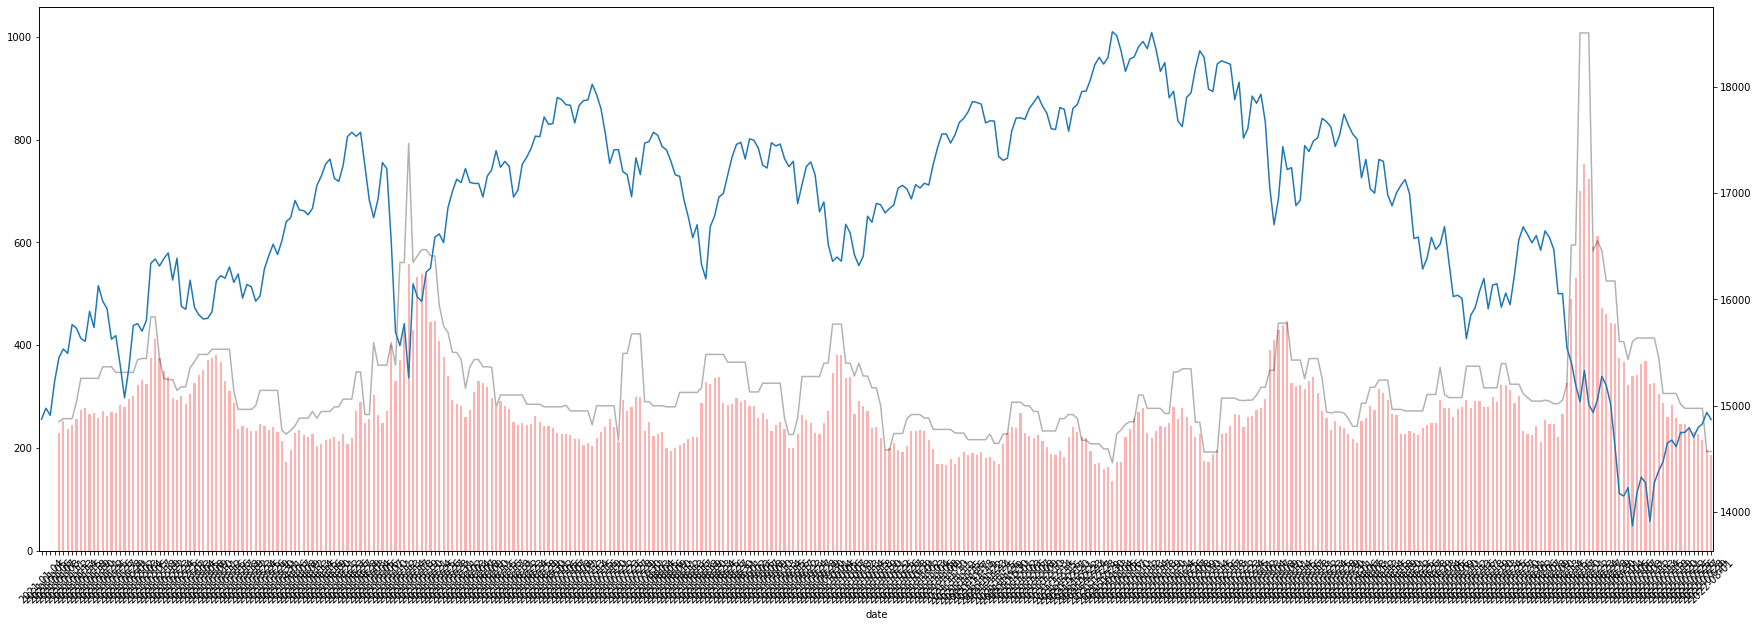

In [12]:
option_fair_price.set_index('date')['close'].plot(secondary_y=True, figsize=(30,10), label='close')
option_fair_price.set_index('date')['op_fair_price'].rolling(5).quantile(0.75).plot(label='op_fair_price', color='black', alpha=0.3)
option_fair_price.set_index('date')['op_fair_price'].rolling(5).mean().plot.bar(label='op_fair_price', color='r', alpha=0.3, rot=45)

### plot atr

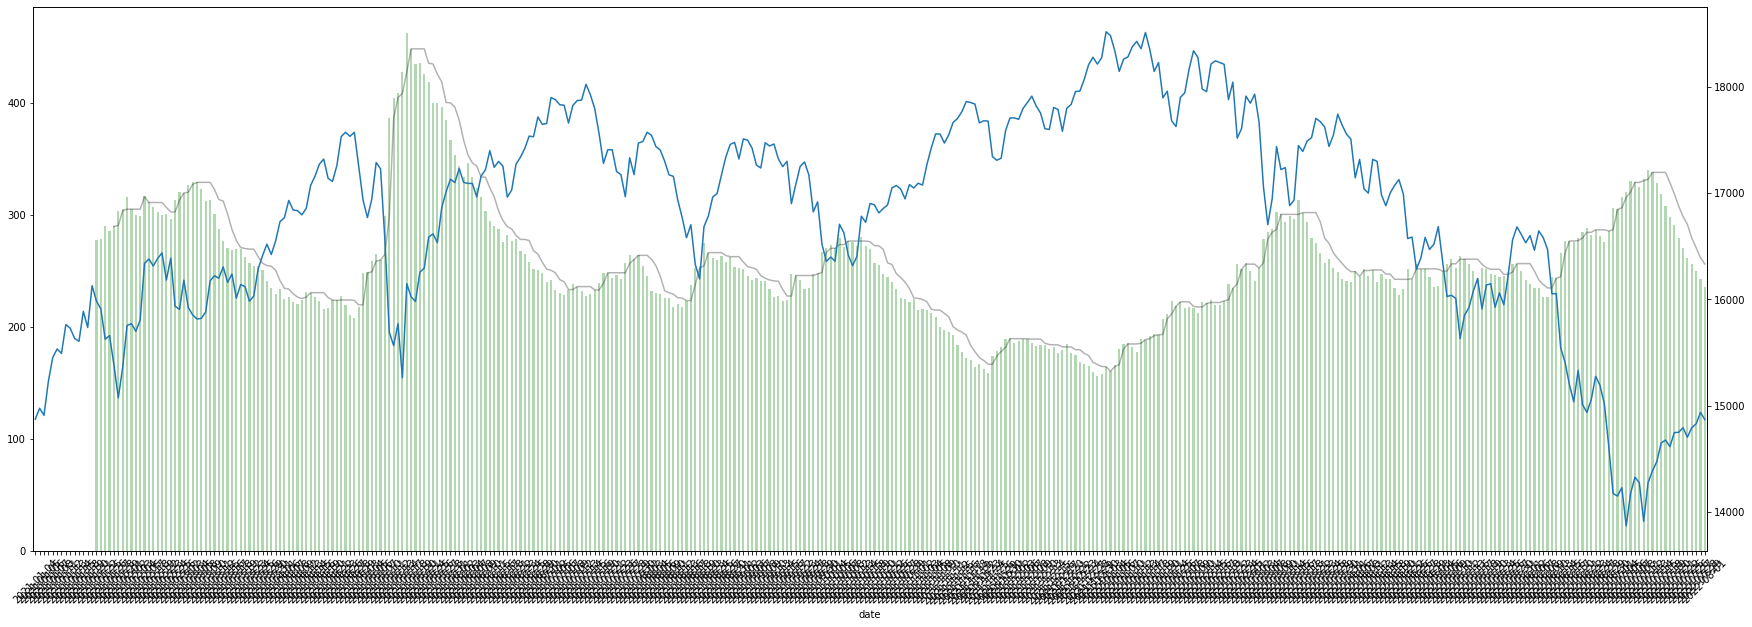

In [13]:
option_fair_price.set_index('date')['close'].plot(secondary_y=True, figsize=(30,10), label='close')
option_fair_price.set_index('date')['atr'].rolling(5).quantile(0.75).plot(label='atr', color='black', alpha=0.3)
option_fair_price.set_index('date')['atr'].plot.bar(label='atr', color='g', alpha=0.3, rot=45)
# plt.legend()
# plt.locator_params(axis='x', nbins=round(len(option_fair_price) / 20))

In [14]:
option_fair_price.tail(50)

,date,contract,strike_price,op_fair_price,day,close,atr
333,2022-05-23,202205W4,16150.0,190.0,Monday,16147.0,246.684112
334,2022-05-24,202205W4,15950.0,423.0,Tuesday,15926.0,246.349532
335,2022-05-25,202206W1,16050.0,324.0,Wednesday,16060.0,244.467423
336,2022-05-26,202206W1,15950.0,306.0,Thursday,15950.0,245.291178
337,2022-05-27,202206W1,16250.0,194.0,Friday,16230.0,248.841808
338,2022-05-30,202206W1,16550.0,261.0,Monday,16560.0,256.353108
339,2022-05-31,202206W1,16700.0,80.0,Tuesday,16682.0,256.327886
340,2022-06-01,202206W2,16600.0,298.0,Wednesday,16610.0,249.661608
341,2022-06-02,202206W2,16550.0,291.0,Thursday,16532.0,241.757208
342,2022-06-06,202206W2,16600.0,283.0,Monday,16600.0,237.703121
